### Metrics calculation and some plots
Use this notebook to calculate the BWT and FWT scores for the images the network. This works for the registration predictions as well as U-Net predictions. Just set the paths to the networks predictions correctly and the notebook will do the rest.

#### Set paths

In [5]:
nca_exps = '/media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Prost/Experiments/Seq'
nca_CL = '/media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Prost/Experiments/Adjust'
# nca_CL = '/media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Prost/Experiments/Adjust_advanced'
# reh_exps =   '/media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Prost/Experiments/Reh'
ewc_exps =   '/media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Prost/Experiments/EWC'
rwalk_exps = '/media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Prost/Experiments/RWalk'

#### Import necessary libraries

In [2]:
from math import pi
import numpy as np
import pandas as pd
import seaborn as sns
from time import sleep
import SimpleITK as sitk
import matplotlib.pyplot as plt
from torch.autograd import Variable
import os, copy, monai, torch
from tqdm.notebook import trange, tqdm

#### Helpful functions and other stuffs

In [3]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])
    
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

### NCA results

In [6]:
models = [x for x in os.listdir(nca_exps) if 'm3d_nca' in x.lower()]

models.sort()
dices_s = dict()
for model in models:
    dices_s[model.replace('_None', '').replace('M3D_NCA_', '').replace('Prost', '')] = dict()
    preds_ = [x for x in os.listdir(os.path.join(nca_exps, model)) if 'inference' in x]

    for pred in preds_:
        preds = os.path.join(nca_exps, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        
        for datas in ds:
            dices_ = list()
            dices_s[model.replace('_None', '').replace('M3D_NCA_', '').replace('Prost', '')][datas.split('_')[0].replace('Task', '')] = dict()
            cases = [x for x in os.listdir(os.path.join(preds, datas)) if 'DS_' not in x]
            for case in cases:
                dices_s[model.replace('_None', '').replace('M3D_NCA_', '').replace('Prost', '')][datas.split('_')[0].replace('Task', '')][case] = dict()
                gt = np.int32(sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'seg_gt.nii.gz'))))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'pred_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu().item()
                dices_s[model.replace('_None', '').replace('M3D_NCA_', '').replace('Prost', '')][datas.split('_')[0].replace('Task', '')][case]['pred'] = np.round(dice, 4)
                dices_.append(dice)

            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            
            dices_s[model.replace('_None', '').replace('M3D_NCA_', '').replace('Prost', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_moved'] = np.mean(dices_)
            dices_s[model.replace('_None', '').replace('M3D_NCA_', '').replace('Prost', '')][datas.split('_')[0].replace('Task', '')]['mean_std_moved'] = np.std(dices_)
            dices_s[model.replace('_None', '').replace('M3D_NCA_', '').replace('Prost', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
        print()

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Prost/Experiments/Seq/M3D_NCA_Prost76_None/inference..
Dice for model M3D_NCA_Prost76_None:
Task76_DecathProst: Mean dice +/- std: 85.26 (5.68)
Task77_ISBI: Mean dice +/- std: 42.43 (31.55)
Task78_I2CVB: Mean dice +/- std: 8.92 (12.62)
Task79_UCL: Mean dice +/- std: 26.97 (26.97)

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Prost/Experiments/Seq/M3D_NCA_Prost77_None/inference..
Dice for model M3D_NCA_Prost77_None:
Task76_DecathProst: Mean dice +/- std: 53.41 (25.86)
Task77_ISBI: Mean dice +/- std: 87.7 (5.43)
Task78_I2CVB: Mean dice +/- std: 0.0 (0.0)
Task79_UCL: Mean dice +/- std: 24.31 (24.31)

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Prost/Experiments/Seq/M3D_NCA_Prost78_None/inference..
Dice for model M3D_NCA_Prost78_None:
Task76_DecathProst: Mean dice +/- std: 3.7 (7.47)
Task77_ISBI: Mean dice +/- std: 0.

In [10]:
models = [x for x in os.listdir(nca_CL) if 'm3d_nca' in x.lower()]

models.sort()
dices_cl = dict()
for model in models:
    dices_cl[model.replace('_CL_adjust_dict_new_p0s_None', '').replace('M3D_NCA_', '').replace('Prost', '')] = dict()
    preds_ = [x for x in os.listdir(os.path.join(nca_CL, model)) if 'inference' in x]

    for pred in preds_:
        preds = os.path.join(nca_CL, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        
        for datas in ds:
            dices_ = list()
            dices_cl[model.replace('_CL_adjust_dict_new_p0s_None', '').replace('M3D_NCA_', '').replace('Prost', '')][datas.split('_')[0].replace('Task', '')] = dict()
            cases = [x for x in os.listdir(os.path.join(preds, datas)) if 'DS_' not in x]
            for case in cases:
                dices_cl[model.replace('_CL_adjust_dict_new_p0s_None', '').replace('M3D_NCA_', '').replace('Prost', '')][datas.split('_')[0].replace('Task', '')][case] = dict()
                gt = np.int32(sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'seg_gt.nii.gz'))))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'pred_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu().item()
                dices_cl[model.replace('_CL_adjust_dict_new_p0s_None', '').replace('M3D_NCA_', '').replace('Prost', '')][datas.split('_')[0].replace('Task', '')][case]['pred'] = np.round(dice, 4)
                dices_.append(dice)

            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            
            dices_cl[model.replace('_CL_adjust_dict_new_p0s_None', '').replace('M3D_NCA_', '').replace('Prost', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_moved'] = np.mean(dices_)
            dices_cl[model.replace('_CL_adjust_dict_new_p0s_None', '').replace('M3D_NCA_', '').replace('Prost', '')][datas.split('_')[0].replace('Task', '')]['mean_std_moved'] = np.std(dices_)
            dices_cl[model.replace('_CL_adjust_dict_new_p0s_None', '').replace('M3D_NCA_', '').replace('Prost', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
        print()

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Prost/Experiments/Adjust/M3D_NCA_Prost76_CL_adjust_dict_new_p0s_None/inference..
Dice for model M3D_NCA_Prost76_CL_adjust_dict_new_p0s_None:
Task76_DecathProst: Mean dice +/- std: 83.99 (4.22)
Task77_ISBI: Mean dice +/- std: 34.43 (32.43)
Task78_I2CVB: Mean dice +/- std: 10.19 (8.32)
Task79_UCL: Mean dice +/- std: 25.36 (25.36)

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Prost/Experiments/Adjust/M3D_NCA_Prost77_CL_adjust_dict_new_p0s_None/inference..
Dice for model M3D_NCA_Prost77_CL_adjust_dict_new_p0s_None:
Task76_DecathProst: Mean dice +/- std: 55.08 (32.09)
Task77_ISBI: Mean dice +/- std: 85.97 (7.47)
Task78_I2CVB: Mean dice +/- std: 22.19 (26.22)
Task79_UCL: Mean dice +/- std: 27.17 (27.17)

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Prost/Experiments/Adjust/M3D_NCA_Prost78_CL_adjust_dict_new_p0s_None/infe

In [ ]:
# Rehearsal
models = [x for x in os.listdir(reh_exps)  if 'm3d_nca' in x.lower()]

models.sort()
dices_reh = dict()
for model in models:
    dices_reh[model.replace('_reh_None', '').replace('M3D_NCA_', '').replace('Prost', '')] = dict()
    preds_ = [x for x in os.listdir(os.path.join(reh_exps, model)) if 'inference' in x]
    for pred in preds_:
        preds = os.path.join(reh_exps, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        
        for datas in ds:
            dices_ = list()
            dices_reh[model.replace('_reh_None', '').replace('M3D_NCA_', '').replace('Prost', '')][datas.split('_')[0].replace('Task', '')] = dict()
            cases = [x for x in os.listdir(os.path.join(preds, datas)) if 'DS_' not in x]
            for case in cases:
                dices_reh[model.replace('_reh_None', '').replace('M3D_NCA_', '').replace('Prost', '')][datas.split('_')[0].replace('Task', '')][case] = dict()
                gt = np.int32(sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'seg_gt.nii.gz'))))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'pred_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu().item()
                dices_reh[model.replace('_reh_None', '').replace('M3D_NCA_', '').replace('Prost', '')][datas.split('_')[0].replace('Task', '')][case]['pred'] = np.round(dice, 4)
                dices_.append(dice)

            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            
            dices_reh[model.replace('_reh_None', '').replace('M3D_NCA_', '').replace('Prost', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_moved'] = np.mean(dices_)
            dices_reh[model.replace('_reh_None', '').replace('M3D_NCA_', '').replace('Prost', '')][datas.split('_')[0].replace('Task', '')]['mean_std_moved'] = np.std(dices_)
            dices_reh[model.replace('_reh_None', '').replace('M3D_NCA_', '').replace('Prost', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
        print()

In [7]:
# EWC
models = [x for x in os.listdir(ewc_exps)  if 'm3d_nca' in x.lower()]

models.sort()
dices_ewc = dict()
for model in models:
    dices_ewc[model.replace('_ewc_None', '').replace('M3D_NCA_', '').replace('Prost', '')] = dict()
    preds_ = [x for x in os.listdir(os.path.join(ewc_exps, model)) if 'inference' in x]
    for pred in preds_:
        preds = os.path.join(ewc_exps, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        
        for datas in ds:
            dices_ = list()
            dices_ewc[model.replace('_ewc_None', '').replace('M3D_NCA_', '').replace('Prost', '')][datas.split('_')[0].replace('Task', '')] = dict()
            cases = [x for x in os.listdir(os.path.join(preds, datas)) if 'DS_' not in x]
            for case in cases:
                dices_ewc[model.replace('_ewc_None', '').replace('M3D_NCA_', '').replace('Prost', '')][datas.split('_')[0].replace('Task', '')][case] = dict()
                gt = np.int32(sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'seg_gt.nii.gz'))))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'pred_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu().item()
                dices_ewc[model.replace('_ewc_None', '').replace('M3D_NCA_', '').replace('Prost', '')][datas.split('_')[0].replace('Task', '')][case]['pred'] = np.round(dice, 4)
                dices_.append(dice)

            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            
            dices_ewc[model.replace('_ewc_None', '').replace('M3D_NCA_', '').replace('Prost', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_moved'] = np.mean(dices_)
            dices_ewc[model.replace('_ewc_None', '').replace('M3D_NCA_', '').replace('Prost', '')][datas.split('_')[0].replace('Task', '')]['mean_std_moved'] = np.std(dices_)
            dices_ewc[model.replace('_ewc_None', '').replace('M3D_NCA_', '').replace('Prost', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
        print()

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Prost/Experiments/EWC/M3D_NCA_Prost76_ewc_None/inference..
Dice for model M3D_NCA_Prost76_ewc_None:
Task76_DecathProst: Mean dice +/- std: 85.26 (5.68)
Task77_ISBI: Mean dice +/- std: 42.43 (31.55)
Task78_I2CVB: Mean dice +/- std: 8.92 (12.62)
Task79_UCL: Mean dice +/- std: 26.97 (26.97)

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Prost/Experiments/EWC/M3D_NCA_Prost77_ewc_None/inference..
Dice for model M3D_NCA_Prost77_ewc_None:
Task76_DecathProst: Mean dice +/- std: 53.41 (25.86)
Task77_ISBI: Mean dice +/- std: 87.7 (5.43)
Task78_I2CVB: Mean dice +/- std: 0.0 (0.0)
Task79_UCL: Mean dice +/- std: 24.31 (24.31)

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Prost/Experiments/EWC/M3D_NCA_Prost78_ewc_None/inference..
Dice for model M3D_NCA_Prost78_ewc_None:
Task76_DecathProst: Mean dice +/- std: 3.7 (7.47)
Task77_ISB

In [8]:
# RWalk
models = [x for x in os.listdir(rwalk_exps)  if 'm3d_nca' in x.lower()]

models.sort()
dices_rwalk = dict()
for model in models:
    dices_rwalk[model.replace('_rwalk_None', '').replace('M3D_NCA_', '').replace('Prost', '')] = dict()
    preds_ = [x for x in os.listdir(os.path.join(rwalk_exps, model)) if 'inference' in x]
    for pred in preds_:
        preds = os.path.join(rwalk_exps, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        
        for datas in ds:
            dices_ = list()
            dices_rwalk[model.replace('_rwalk_None', '').replace('M3D_NCA_', '').replace('Prost', '')][datas.split('_')[0].replace('Task', '')] = dict()
            cases = [x for x in os.listdir(os.path.join(preds, datas)) if 'DS_' not in x]
            for case in cases:
                dices_rwalk[model.replace('_rwalk_None', '').replace('M3D_NCA_', '').replace('Prost', '')][datas.split('_')[0].replace('Task', '')][case] = dict()
                gt = np.int32(sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'seg_gt.nii.gz'))))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'pred_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu().item()
                dices_rwalk[model.replace('_rwalk_None', '').replace('M3D_NCA_', '').replace('Prost', '')][datas.split('_')[0].replace('Task', '')][case]['pred'] = np.round(dice, 4)
                dices_.append(dice)

            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            
            dices_rwalk[model.replace('_rwalk_None', '').replace('M3D_NCA_', '').replace('Prost', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_moved'] = np.mean(dices_)
            dices_rwalk[model.replace('_rwalk_None', '').replace('M3D_NCA_', '').replace('Prost', '')][datas.split('_')[0].replace('Task', '')]['mean_std_moved'] = np.std(dices_)
            dices_rwalk[model.replace('_rwalk_None', '').replace('M3D_NCA_', '').replace('Prost', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
        print()

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Prost/Experiments/RWalk/M3D_NCA_Prost76_rwalk_None/inference..
Dice for model M3D_NCA_Prost76_rwalk_None:


Task76_DecathProst: Mean dice +/- std: 85.26 (5.68)
Task77_ISBI: Mean dice +/- std: 42.43 (31.55)
Task78_I2CVB: Mean dice +/- std: 8.92 (12.62)
Task79_UCL: Mean dice +/- std: 26.97 (26.97)

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Prost/Experiments/RWalk/M3D_NCA_Prost77_rwalk_None/inference..
Dice for model M3D_NCA_Prost77_rwalk_None:
Task76_DecathProst: Mean dice +/- std: 53.41 (25.86)
Task77_ISBI: Mean dice +/- std: 87.7 (5.43)
Task78_I2CVB: Mean dice +/- std: 0.0 (0.0)
Task79_UCL: Mean dice +/- std: 24.31 (24.31)

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Prost/Experiments/RWalk/M3D_NCA_Prost78_rwalk_None/inference..
Dice for model M3D_NCA_Prost78_rwalk_None:
Task76_DecathProst: Mean dice +/- std: 3.7 (7.47)
Task77_ISBI: Mean dice +/- std: 0.1 (0.44)
Task78_I2CVB: Mean dice +/- std: 71.2 (4.49)
Task79_UCL: Mean dice +/- std: 0.0 (0.0)

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025_N

In [11]:
data = {'NCA': dices_s, 'NCA_adjust': dices_cl, 'EWC': dices_ewc, 'RWalk': dices_rwalk, #'Rehearsal': dices_reh
       }

#### Forgetting, Positive Backward Transfer, Remembering and Forward Transfer

In [12]:
tasks = ['79', '78', '77', '76']
methods = ['NCA', 'NCA_adjust', 'EWC', 'RWalk']#, 'Rehearsal']
B_T, F_T, F_NEG, F_POS, B_TP, FOR, REM, Dice, Dice_F, Dice_L, STD = dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict()
Dice_2 = dict()
Dice_3 = dict()

all_t_j = '_'.join(tasks)
for m in methods:
    B_T[m], F_T[m], F_NEG[m], F_POS[m], B_TP[m], FOR[m], REM[m], Dice[m], Dice_F[m], Dice_L[m], STD[m] = dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict()
    Dice_2[m] = dict()
    Dice_3[m] = dict()
    t_list = list()
    for t in tasks:
        t_list.append(t)
        Dice_t_all = (data[m][all_t_j][t]['mean_dice_moved'],
                        data[m][all_t_j][t]['mean_std_moved'])
        
        Dice_t = (data[m]['_'.join(t_list)][t]['mean_dice_moved'],
                    data[m]['_'.join(t_list)][t]['mean_std_moved'])
        
        if len(t_list) > 1:
            Dice_t_prev = (data[m]['_'.join(t_list[:-1])][t]['mean_dice_moved'],
                            data[m]['_'.join(t_list[:-1])][t]['mean_std_moved'])
            F_T[m][t] = Dice_t_prev[0] - data[m][t][t]['mean_dice_moved']
            F_NEG[m][t] = abs(min(F_T[m][t], 0))
            F_POS[m][t] = 1 - abs(min(F_T[m][t], 0))
        
        if '_'.join(t_list) == all_t_j: # Only add this once
            Dice_F[m][t] = data[m][all_t_j][tasks[0]]['mean_dice_moved']
            Dice_2[m][t] = data[m][all_t_j][tasks[1]]['mean_dice_moved']
            Dice_3[m][t] = data[m][all_t_j][tasks[2]]['mean_dice_moved']
            Dice_L[m][t] = data[m][all_t_j][tasks[3]]['mean_dice_moved']
        
        Dice[m][t] = data[m][all_t_j][t]['mean_dice_moved']

        if '_'.join(t_list) != all_t_j:
            B_T[m][t] = Dice_t_all[0] - Dice_t[0]
            B_TP[m][t] = max(B_T[m][t], 0)
            FOR[m][t] = abs(min(B_T[m][t], 0))
            REM[m][t] = 1 - abs(min(B_T[m][t], 0))

In [13]:
print('BWT, FWT [%]')
for m in methods:
    print(m)
    print(np.mean(np.asarray(list(B_T[m].values()))*100), '+\-', np.std(np.asarray(list(B_T[m].values()))*100))
    # print(np.mean(np.asarray(list(REM[m].values()))*100), '+\-', np.std(np.asarray(list(REM[m].values()))*100))
    print(np.mean(np.asarray(list(F_T[m].values()))*100), '+\-', np.std(np.asarray(list(F_T[m].values()))*100))
    # print(np.mean(np.asarray(list(Dice[m].values()))*100), '+\-', np.std(np.asarray(list(Dice[m].values()))*100))

BWT, FWT [%]
NCA
-15.930761189924347 +\- 13.8998668591541
-73.34341009883269 +\- 9.042736079780383
NCA_adjust
-1.2122666562390805 +\- 2.2381776519618604
-81.13357055931412 +\- 5.394578455649369
EWC
-21.411153601689467 +\- 25.02829174085648
-71.12748540728204 +\- 13.222737630187623
RWalk
-1.190299503893281 +\- 0.9573071895770506
-80.41097648840197 +\- 6.511601807150365


In [14]:
print('Mean Dice [%]')
for m in methods:
    print(m)
    print(np.mean(list(Dice[m].values()))*100)

Mean Dice [%]
NCA
56.76730264169283
NCA_adjust
33.47678113280888
EWC
44.620735357360296
RWalk
18.301457328533825


In [15]:
print('Mean Forgetting [%]')
for m in methods:
    print(m)
    print(np.mean(list(FOR[m].values()))*100)

Mean Forgetting [%]
NCA
15.930761189924347
NCA_adjust
1.4510299488695941
EWC
24.352050500197542
RWalk
1.1902995038932809


#### Spider Plots

In [13]:
plt.figure(figsize=(13, 6))

df = pd.DataFrame({
'methods': methods,
'Dice Mean': [np.mean(list(Dice[m].values()))*100 for m in methods],
'100 + BWT': [100 + np.mean(list(B_T[m].values()))*100 for m in methods],
'Dice Last': [np.mean(list(Dice_L[m].values()))*100 for m in methods],
'Dice First': [np.mean(list(Dice_F[m].values()))*100 for m in methods],
'100 + FWT': [100 + np.mean(list(F_T[m].values()))*100 for m in methods]
}) 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider(row, title, color, h_=None):

    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(3, 3, row+1, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    # ax.xaxis.set_tick_params(pad=35)    # Add padding to labels

    # Draw one axe per variable + add labels yet
    plt.xticks(angles[:-1], categories, color='black', size=15)
    
    for i, tick in enumerate(ax.get_xaxis().get_major_ticks()):
        if i == 1 or i == 4:
            tick.set_pad(35)
        else:
            tick.set_pad(15)

    # Draw ylabels
    # ax.set_rlabel_position(0)
    plt.yticks(range(0, 101, 20), [str(x) for x in range(0, 101, 20)], color="grey", size=9)
    plt.ylim(0,100)

    # Ind1
    values=df.loc[row].drop('methods').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color='grey', alpha=0.8, linewidth=2, linestyle='solid')
    if h_ is not None:
        ax.fill(angles, values, color=color, alpha=h_)
    else:
        ax.fill(angles, values, color=color)
            
    # Add a title
    plt.title(title)

<Figure size 1300x600 with 0 Axes>

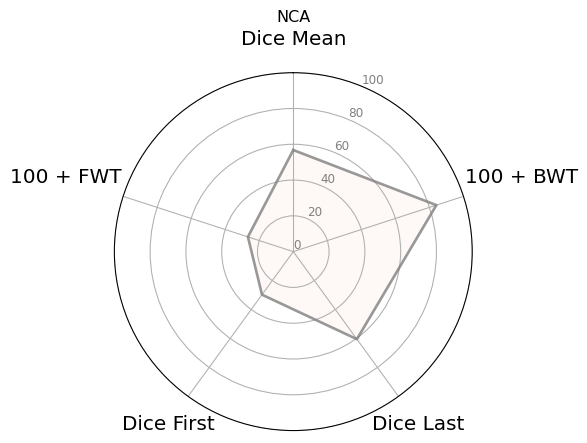

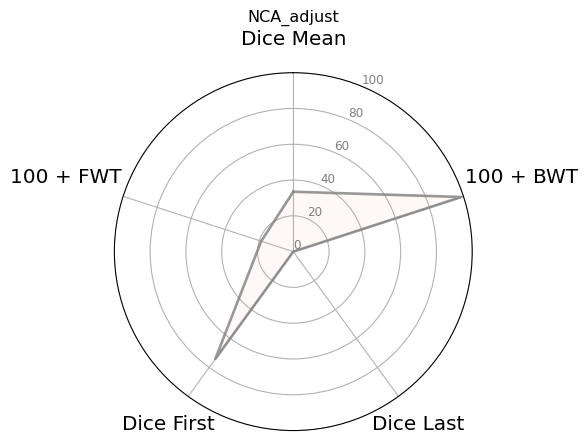

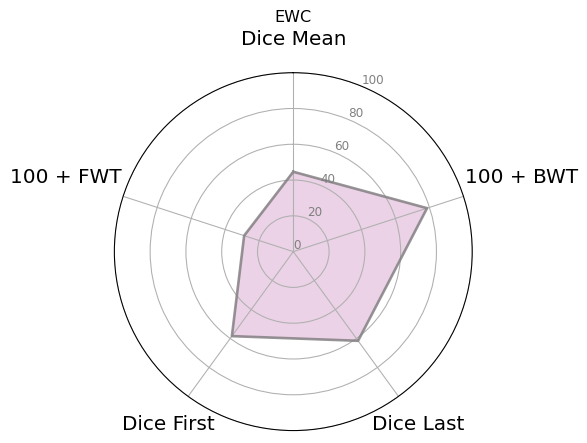

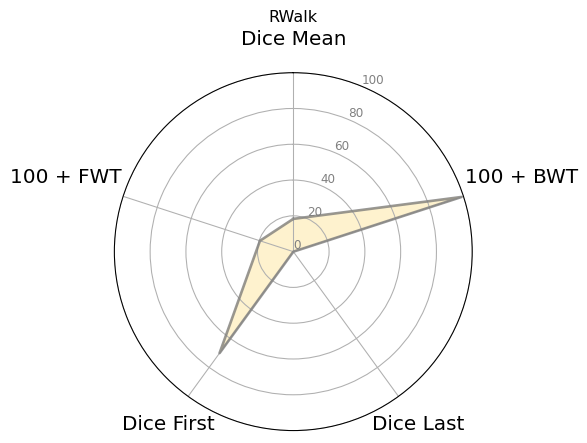

In [14]:
# ------- PART 2: Apply the function to all individuals
colors = {'NCA': '#fae5d6', 'NCA_adjust': '#fae5d6', 'RWalk':'#fec10b', 'EWC':'#9e1e83'}#, 'Rehearsal': '#26a671'

# Loop to plot
for row in range(0, len(df.index)):

    # Plot one after the other to save as pdf for better plotting
    my_dpi=96
    plt.figure(figsize=(13, 13), dpi=my_dpi)
    plt.subplots_adjust(right=1.1, top=1.1)
    plt.tight_layout()

    make_spider(row=row, title=df['methods'][row], color=colors[methods[row]], h_=0.2 if methods[row] not in ['U-Net', 'Atlas Replay'] else None)
    # make_spider( row=row, title=df['method'][row], color=my_palette(row))
    title = df['methods'][row]
    plt.savefig(f'/media/aranem_locale/AR_subs_exps/MICCAI_2024/MICCAI_2024_evaluation/plots/prost_spiders_{title}.pdf', bbox_inches='tight')

In [15]:
plt.figure(figsize=(13, 6))

df = pd.DataFrame({
'methods': methods,
'$\mathcal{T}_{1}$': [np.mean(list(Dice_F[m].values()))*100 for m in methods],
'$\mathcal{T}_{2}$': [np.mean(list(Dice_2[m].values()))*100 for m in methods],
'$\mathcal{T}_{3}$': [np.mean(list(Dice_3[m].values()))*100 for m in methods],
'$\mathcal{T}_{4}$': [np.mean(list(Dice_L[m].values()))*100 for m in methods],
}) 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider(row, title, color, h_=None):

    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(3, 3, row+1, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.xaxis.set_tick_params(pad=15)    # Add padding to labels

    # Draw one axe per variable + add labels yet
    # plt.xticks(angles[:-1], categories, color='black', size=15)
    plt.xticks(angles[:-1], categories, color='black', size=31)
    
    # Draw ylabels
    # ax.set_rlabel_position(0)
    # plt.yticks(range(0, 101, 20), [str(x) for x in range(0, 101, 20)], color="grey", size=11)
    plt.yticks(range(0, 101, 20), [str(x) for x in range(0, 101, 20)], color="grey", size=15)
    plt.ylim(0,100)

    # Ind1
    values=df.loc[row].drop('methods').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color='grey', alpha=0.8, linewidth=2, linestyle='solid')
    if h_ is not None:
        ax.fill(angles, values, color=color, alpha=h_)
    else:
        ax.fill(angles, values, color=color)
            
    # Add a title
    plt.title(title)

<Figure size 1300x600 with 0 Axes>

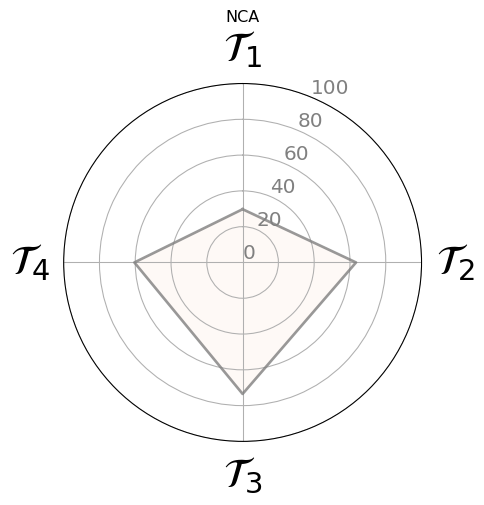

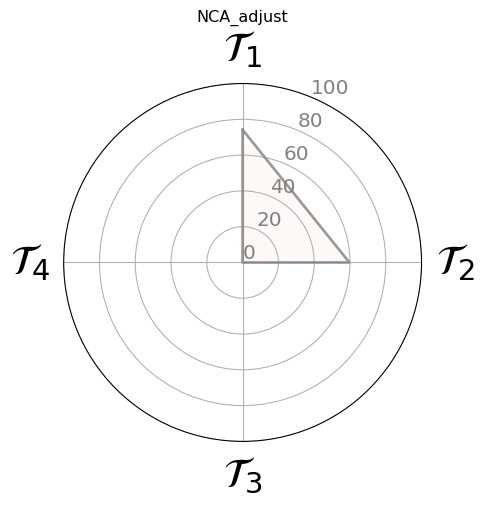

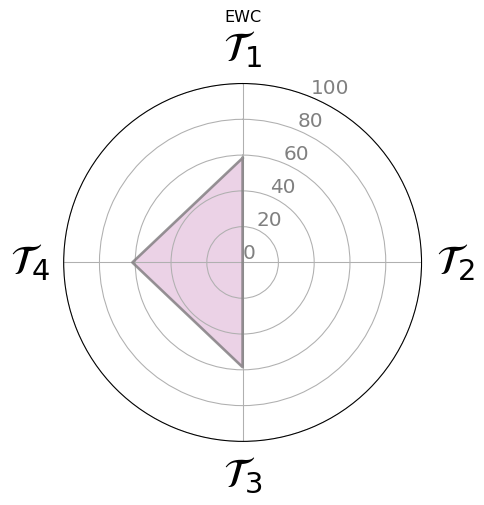

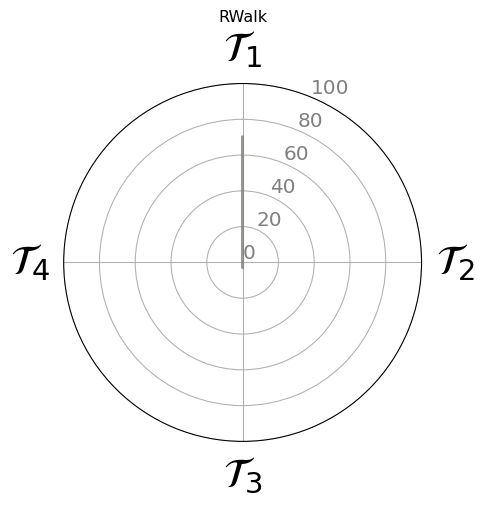

In [16]:
# ------- PART 2: Apply the function to all individuals
colors = {'NCA': '#fae5d6', 'NCA_adjust': '#fae5d6', 'RWalk':'#fec10b', 'EWC':'#9e1e83'}#, 'Rehearsal': '#26a671'

# Loop to plot
for row in range(0, len(df.index)):

    # Plot one after the other to save as pdf for better plotting
    my_dpi=96
    plt.figure(figsize=(13, 13), dpi=my_dpi)
    plt.subplots_adjust(right=1.1, top=1.1)
    plt.tight_layout()

    make_spider(row=row, title=df['methods'][row], color=colors[methods[row]], h_=0.2 if methods[row] not in ['U-Net', 'Atlas Replay'] else None)
    # make_spider( row=row, title=df['method'][row], color=my_palette(row))
    title = df['methods'][row]
    plt.savefig(f'/media/aranem_locale/AR_subs_exps/MICCAI_2024/MICCAI_2024_evaluation/plots/prost_spiders_{title}_dices.pdf', bbox_inches='tight')